In [15]:
# Importing packages + magics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import model as md

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.size'] = 18  
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18


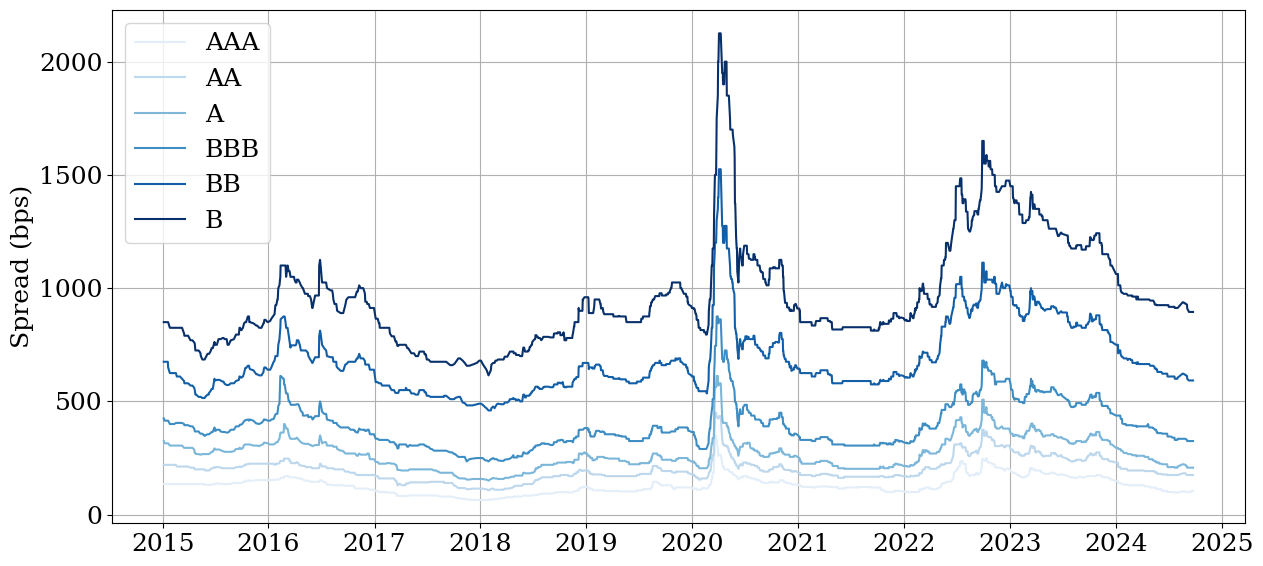

In [16]:

CLO = md.CLOModel()
Spreads_data = CLO.load_historical_spreads()


Spreads_data['Date'] = pd.to_datetime(Spreads_data['Date'])

num_colors = len(Spreads_data.columns) - 1  
colors = plt.cm.Blues(np.linspace(0.1, 1, num_colors))


plt.figure(figsize=(13, 6))
for i, column in enumerate(Spreads_data.columns[1:]):  
    plt.plot(Spreads_data['Date'], Spreads_data[column], label=column, color=colors[i])

plt.ylabel('Spread (bps)')
plt.legend()
plt.grid(True)
#plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()


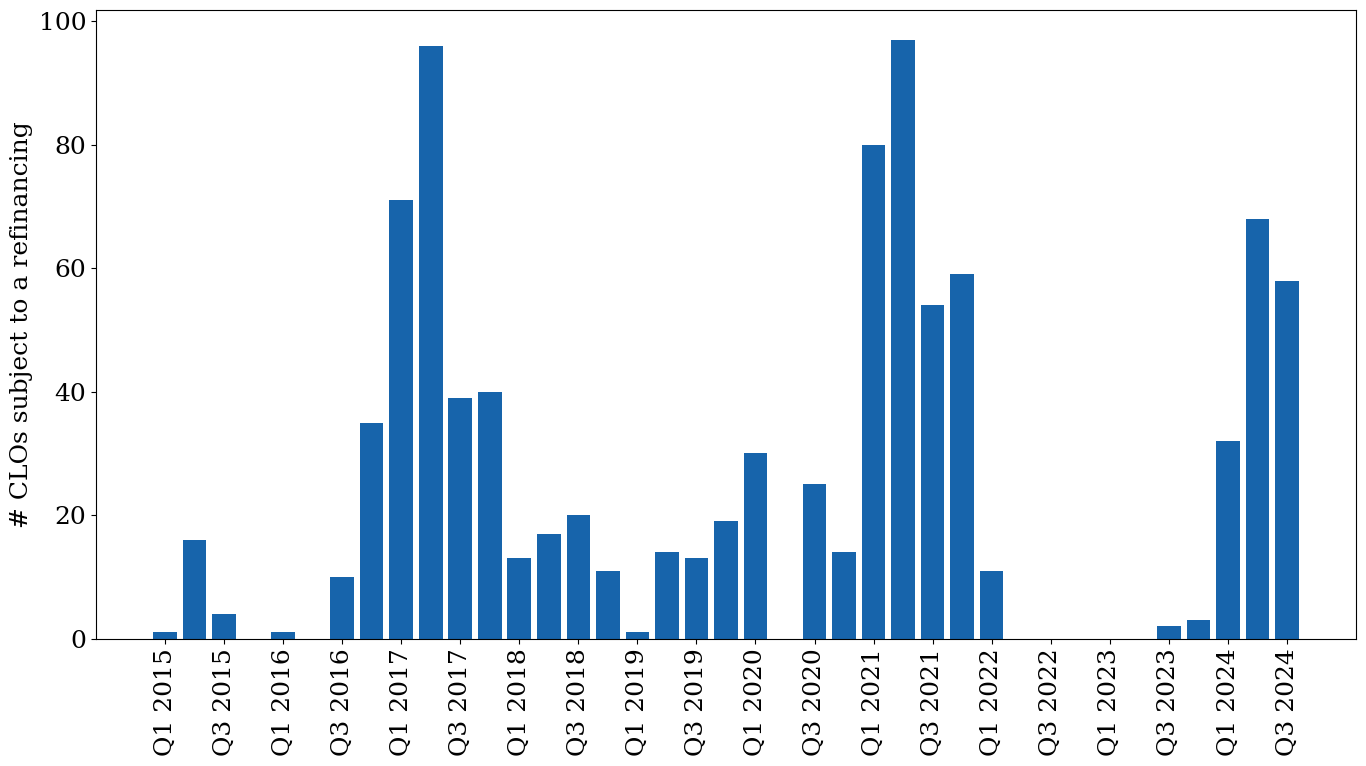

In [17]:

# Load data
CLO = md.CLOModel()
refi_data = CLO.load_historical_refinance_data()

# Set up color
colors = plt.cm.Blues(np.linspace(0.8, 1, 1))

# Plotting
plt.figure(figsize=(14, 8))
plt.bar(refi_data["Quarter"], refi_data["Count"], color=colors[0])

# Display tick marks for every second quarter
plt.xticks(np.arange(0, len(refi_data["Quarter"]), 2), refi_data["Quarter"][::2], rotation=90)

# Labeling
plt.ylabel("# CLOs subject to a refinancing")
#plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Display default rates and how the adjustment is made**

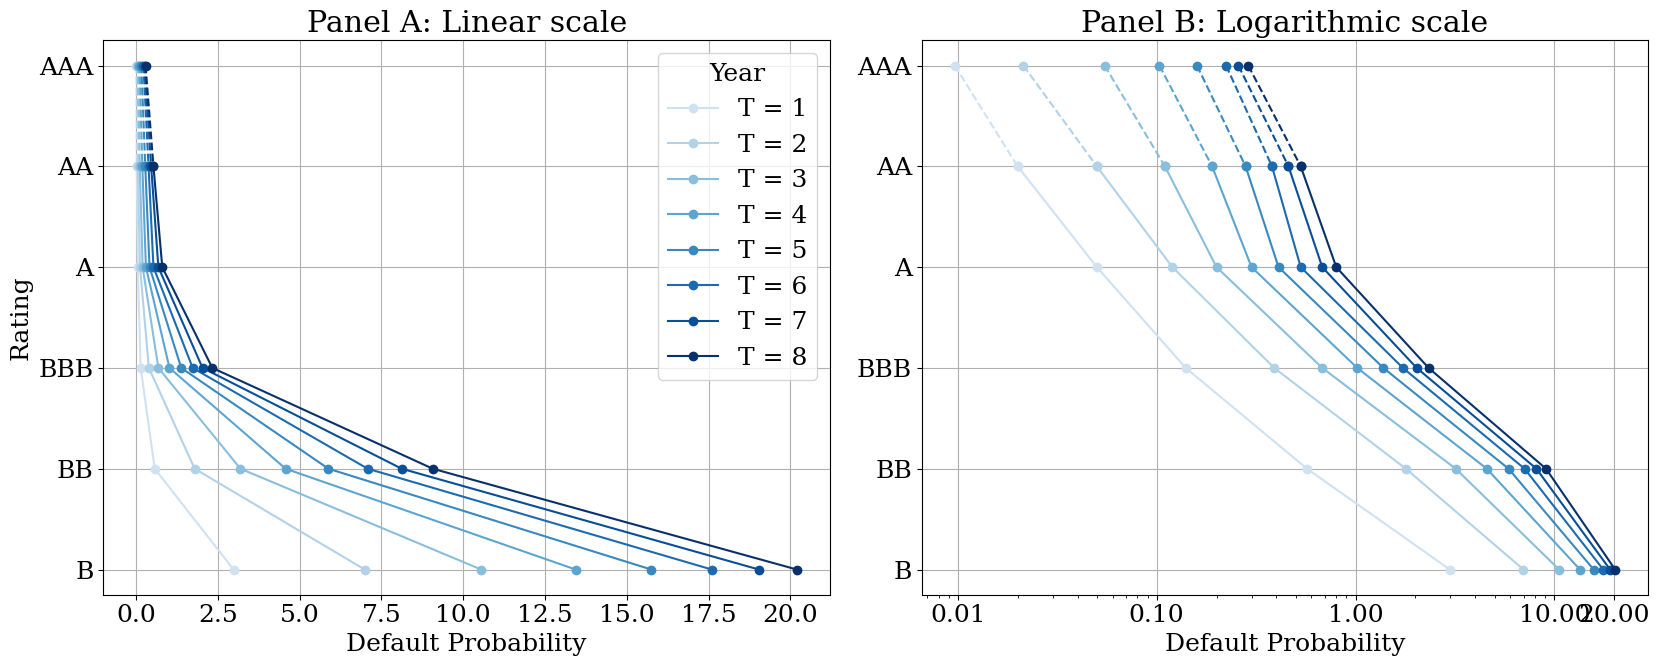

In [18]:
from matplotlib.ticker import ScalarFormatter, LogLocator

CLO = md.CLOModel()

df = CLO.load_default()  

colors = plt.cm.Blues(np.linspace(0.2, 1, len(df.columns)))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7)) 

# Plot the first plot with a linear x-axis
for i, column in enumerate(df.columns):
    # Dashed line for AAA to AA
    ax1.plot([df.loc['AAA', column], df.loc['AA', column]], ['AAA', 'AA'], 
             marker='o', color=colors[i], linestyle='--')
    # Solid line for AA to B
    ax1.plot(df.loc['AA':'B', column], df.loc['AA':'B'].index, 
             marker='o', color=colors[i], label=f'T = {column}')

ax1.set_xlabel('Default Probability')
ax1.set_ylabel('Rating')
ax1.set_title('Panel A: Linear scale')
ax1.legend(title="Year", loc='upper right', bbox_to_anchor=(1, 1)) 
ax1.grid(True)
ax1.invert_yaxis()

# Plot the second plot with a logarithmic x-axis
for i, column in enumerate(df.columns):
    # Dashed line for AAA to AA
    ax2.plot([df.loc['AAA', column], df.loc['AA', column]], ['AAA', 'AA'], 
             marker='o', color=colors[i], linestyle='--')
    # Solid line for AA to B
    ax2.plot(df.loc['AA':'B', column], df.loc['AA':'B'].index, 
             marker='o', color=colors[i])

ax2.set_xlabel('Default Probability')
ax2.set_xscale('log')  # Set x-axis to logarithmic
ax2.set_title('Panel B: Logarithmic scale')
ax2.grid(True)
ax2.invert_yaxis()


ax2.set_xticks([0.01, 0.1, 1, 10, 20])
ax2.get_xaxis().set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(axis='x', style='plain')


plt.tight_layout()
plt.show()


**Plotting example of a CLO**

71.81379525844287
111
58.516539542740084
8790.562827285514


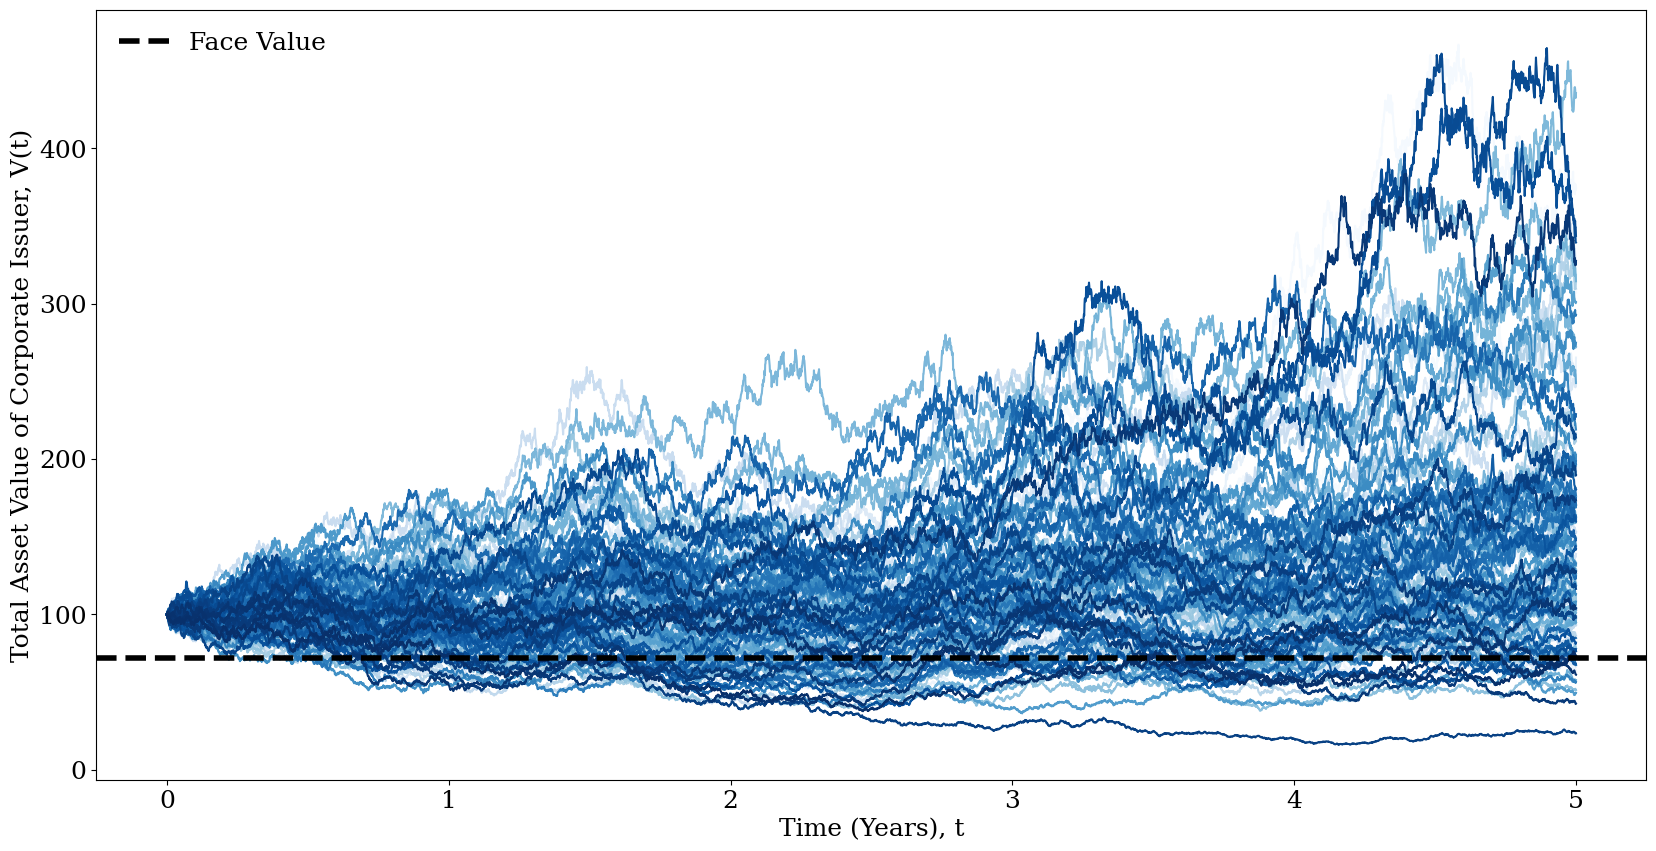

In [19]:

CLO = md.CLOModel()
sim_model = md.CLOModel(n=1)
face_value = CLO.face_value() 
print(face_value)
time = np.linspace(0, sim_model.T, sim_model.m * sim_model.T + 1)
asset_paths = sim_model.GBM_fig()
final_values = asset_paths[-1,0,:]

print(len(final_values[final_values > face_value])) #Number of issuers able to repay in full
print(np.mean(final_values[final_values < face_value]) if len(final_values[final_values < face_value]) > 0 else None
) #Average recovery of issuers defaulting
print(np.sum(np.minimum(final_values, face_value))) #Total payoff

payoff = np.sum(np.minimum(final_values, face_value))



colors = plt.cm.Blues(np.linspace(0, 1, CLO.j))

plt.figure(figsize=(20, 10))
for i in range(asset_paths.shape[2]):
    plt.plot(time, asset_paths[:, 0, i], color=colors[i])

plt.axhline(y=face_value, color='black', linestyle='--', linewidth=4, label='Face Value')


plt.legend(frameon=False)


plt.xlabel('Time (Years), t')
plt.ylabel('Total Asset Value of Corporate Issuer, V(t)')
plt.grid(False)

plt.show()


**Simulate CLOs distribution under the physical measure to find face values**

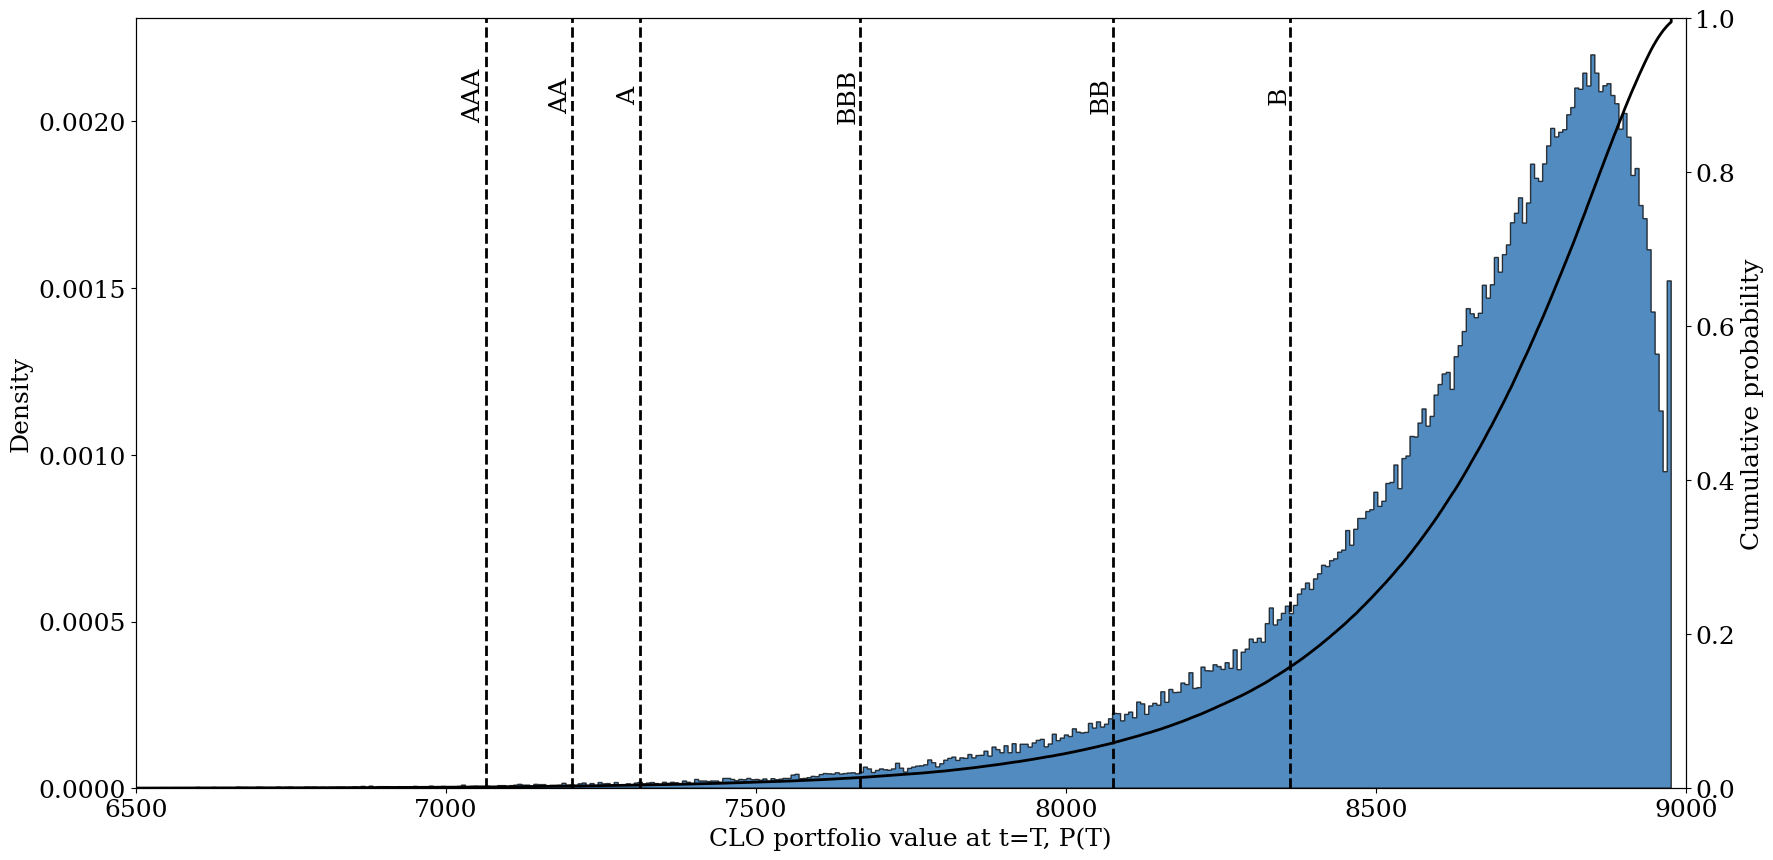

In [20]:
Baseline = md.CLOModel(n=200000)
CLO_cashflows = Baseline.SPV_value()
default_probabilities = Baseline.load_default().loc[:'B', [Baseline.T]]
default_probabilities.rename(columns={Baseline.T: 'default probability'}, inplace=True)
default_probabilities['aggregate face value'] = np.quantile(CLO_cashflows, np.where(default_probabilities['default probability'].isna(), 1, default_probabilities['default probability'].values / 100))

colors = plt.cm.Blues(np.linspace(0.8, 1, 2))

fig, ax1 = plt.subplots(figsize=(20, 10))
# Adjusted histogram for boxes around columns
ax1.hist(CLO_cashflows, bins=500, density=True, alpha=0.75, color=colors[0], edgecolor='black', histtype='stepfilled')
ax1.set_xlabel('CLO portfolio value at t=T, P(T)')
ax1.set_ylabel('Density')
ax1.set_xlim(6500, 9000)

# Plot vertical dashed lines and text for each rating
for index, row in default_probabilities.iterrows():
    aggregate_value = row['aggregate face value']
    # Add the vertical dashed line
    ax1.axvline(aggregate_value, color='black', linestyle='--', linewidth=2)
    
    # Add a rotated marker for the rating
    ax1.text(aggregate_value, ax1.get_ylim()[1] * 0.9, index, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=18)

# Create second axis for CDF
ax2 = ax1.twinx()
sorted_data = np.sort(CLO_cashflows)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plot the CDF on the second axis
ax2.plot(sorted_data, cdf, linewidth=2, color='black', label='CDF')
ax2.set_ylabel('Cumulative probability')
ax2.set_ylim(0, 1)

# Display the plot
plt.show()


In [21]:
CLO = md.CLOModel()

print(CLO.result_table_with_equity())

        default probability  aggregate face value  aggregate market value   face value          %  market value      Price      Yield     Spread
AAA                0.159446           7064.442202             5820.814100  7064.442202  78.697327   5820.814100  82.395948   3.872679   0.032679
AA                 0.280000           7204.324815             5931.843837   139.882613   1.558281    111.029737  79.373508   4.620111   0.780111
A                  0.410000           7313.325658             6017.097268   109.000843   1.214261     85.253431  78.213552   4.914545   1.074545
BBB                1.380000           7667.613551             6282.371306   354.287893   3.946739    265.274038  74.875276   5.786929   1.946929
BB                 5.880000           8076.040978             6547.061578   408.427428   4.549849    264.690272  64.807174   8.675078   4.835078
B                 15.750000           8362.084570             6684.928593   286.043591   3.186503    137.867016  48.197904  14.597

In [9]:
BaselineCLO = CLO.result_table_with_equity()[['aggregate face value', 'face value', 'market value', 'Yield']]
Cashflows = CLO.SPV_value(risk_neutral=False)

tranche_limits = BaselineCLO['aggregate face value']
tranche_limits = tranche_limits.diff().fillna(tranche_limits.iloc[0])  # Calculate the differences between tranches
tranche_market_values = BaselineCLO['market value']

# Initialize a dictionary to store total returns for each tranche
tranche_total_returns = {tranche: [] for tranche in tranche_limits.index}

# Distribute cashflows to each tranche and calculate the total return
for cash in Cashflows:
    remaining_cash = cash
    for tranche, limit in zip(tranche_limits.index, tranche_limits):
        if remaining_cash > 0:
            tranche_cashflow = min(limit, remaining_cash)
            remaining_cash -= tranche_cashflow
            # Calculate the total return of the tranche's market value
            if tranche_market_values[tranche] > 0:  # Avoid division by zero
                total_return = (tranche_cashflow / tranche_market_values[tranche]) - 1
                tranche_total_returns[tranche].append(total_return)
        else:
            tranche_total_returns[tranche].append(-1)  # Indicates no cashflow received

# Define return brackets
brackets = [
    (-1.0, -0.8),
    (-0.8, -0.6),
    (-0.6, -0.4),
    (-0.4, -0.2),
    (-0.2, 0.0),
    (0.0, 0.2),
    (0.2, 0.22),
    (0.22, 0.24),
    (0.24, 0.26),
    (0.26, 0.28),
    (0.28, 0.3),
    (0.3, 0.4),
    (0.4, 0.6),
    (0.6, 0.8),
    (0.8, 1.0),
    (1.0, float('inf'))  # Bracket for above 100% returns
]

# Calculate the percentage of returns in each bracket for each tranche
bracket_percentages = {}
for tranche, returns in tranche_total_returns.items():
    bracket_counts = {f"{int(b[0]*100)}% to {int(b[1]*100)}%" if b[1] != float('inf') else "Above 100%": 0 for b in brackets}
    for ret in returns:
        for bracket in brackets:
            if bracket[0] <= ret < (bracket[1] if bracket[1] != float('inf') else float('inf')):
                bracket_key = f"{int(bracket[0]*100)}% to {int(bracket[1]*100)}%" if bracket[1] != float('inf') else "Above 100%"
                bracket_counts[bracket_key] += 1
                break
    # Calculate percentage
    total_returns = len(returns)
    bracket_percentages[tranche] = {k: (v / total_returns) * 100 for k, v in bracket_counts.items()}

# Create DataFrame to display the results
results_df = pd.DataFrame(bracket_percentages)
print(results_df)

                   AAA       AA        A      BBB       BB        B   Equity
-100% to -80%   0.0000   0.1715   0.2990   0.4895   1.6680   6.4770  16.8420
-80% to -60%    0.0000   0.0160   0.0190   0.1005   0.3345   0.6515   1.2100
-60% to -40%    0.0000   0.0220   0.0205   0.1240   0.4205   0.7075   1.2905
-40% to -20%    0.0000   0.0195   0.0200   0.1370   0.5125   0.7760   1.3555
-20% to 0%      0.0010   0.0210   0.0200   0.1615   0.6260   0.8765   1.4620
0% to 20%       0.1175   0.0220   0.0195   0.2085   0.7235   0.9630   1.5405
20% to 22%     99.8815   0.0030   0.0025   0.0235   0.0795   0.0995   0.1550
22% to 24%      0.0000   0.0025   0.0050   0.0230   0.0660   0.1050   0.1760
24% to 26%      0.0000  99.7225   0.0020   0.0230   0.0935   0.0970   0.1605
26% to 28%      0.0000   0.0000  99.5925   0.0225   0.0865   0.0990   0.1665
28% to 30%      0.0000   0.0000   0.0000   0.0235   0.0790   0.0865   0.1570
30% to 40%      0.0000   0.0000   0.0000  98.6635   0.4545   0.5190   0.8435

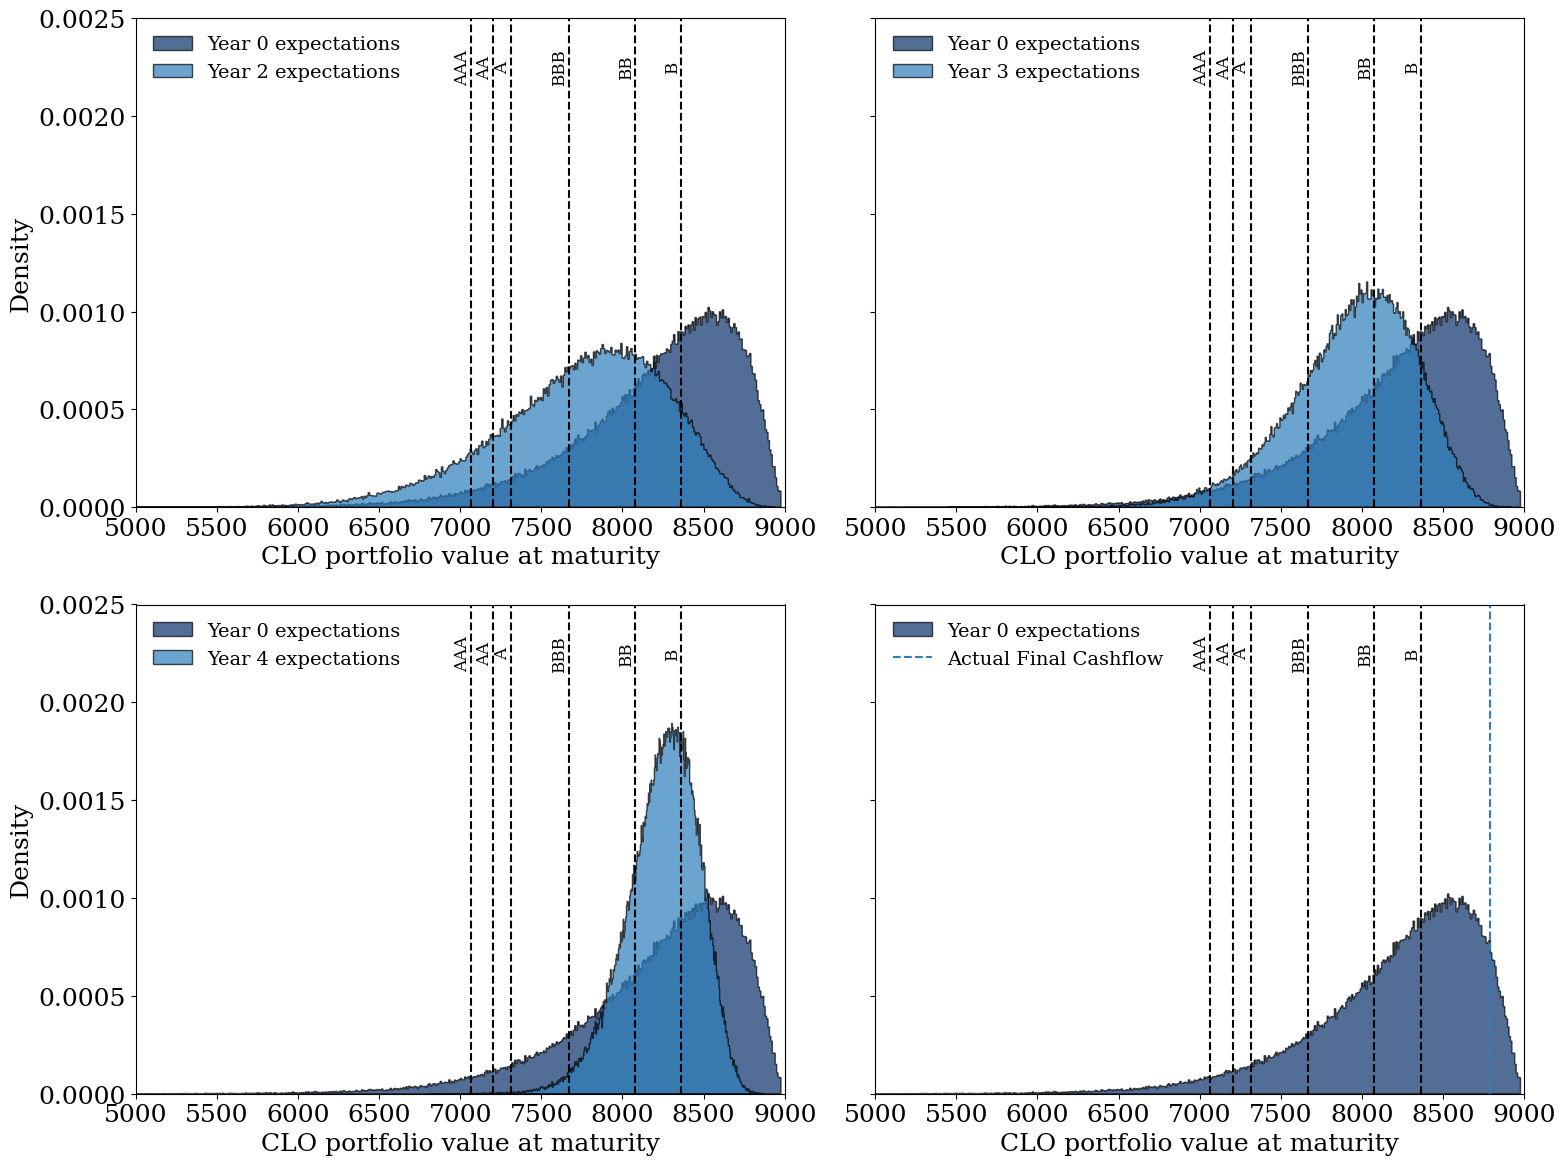

In [10]:

CLO = md.CLOModel(q=200000, j=125)

simulation = 1098
year2 = 2
year3 = 3
year4 = 4

Actual_final_cashflow = 8790
font = 14
# Simulated values
All_simulated_ValuesP = CLO.GBM(risk_neutral=False)
All_simulated_ValuesQ = CLO.GBM(risk_neutral=True)
ExpectedCF_CLO_year0 = CLO.SPV_value(risk_neutral=True)
colors = plt.cm.Blues(np.linspace(0.1, 1, 4))

Simulated_ValuesP = All_simulated_ValuesP[:, simulation, :]
Simulated_ValuesQ = All_simulated_ValuesQ[:, simulation, :]

Informed_values2 = Simulated_ValuesP[year2]
Informed_values3 = Simulated_ValuesP[year3]
Informed_values4 = Simulated_ValuesP[year4]

New_expectation2 = CLO.ExpSimulation(CLO.T - year2, Informed_values2)
New_expectation3 = CLO.ExpSimulation(CLO.T - year3, Informed_values3)
New_expectation4 = CLO.ExpSimulation(CLO.T - year4, Informed_values4)

ExpectedCF_CLO_updated2 = np.sum(New_expectation2, axis=1)
ExpectedCF_CLO_updated3 = np.sum(New_expectation3, axis=1)
ExpectedCF_CLO_updated4 = np.sum(New_expectation4, axis=1)

# Create a figure and 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fixed_ylim = (0, 0.0025)
fixed_xlim = (5000, 9000)  # Example fixed range for the y-axis, adjust as needed

# Plot 1: Year 0 expectations + Year 2 expectations
axes[0, 0].hist(ExpectedCF_CLO_year0, bins=500, alpha=0.7, label='Year 0 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[3])
axes[0, 0].hist(ExpectedCF_CLO_updated2, bins=500, alpha=0.7, label='Year 2 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[2])
axes[0, 0].set_xlabel('CLO portfolio value at maturity')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_ylim(fixed_ylim)
axes[0, 0].set_xlim(fixed_xlim)
axes[0, 0].legend(fontsize=font, frameon=False)

# Plot 2: Year 0 expectations + Year 3 expectations
axes[0, 1].hist(ExpectedCF_CLO_year0, bins=500, alpha=0.7, label='Year 0 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[3])
axes[0, 1].hist(ExpectedCF_CLO_updated3, bins=500, alpha=0.7, label='Year 3 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[2])
axes[0, 1].set_xlabel('CLO portfolio value at maturity')
axes[0, 1].set_ylim(fixed_ylim)
axes[0, 1].set_xlim(fixed_xlim)
axes[0, 1].legend(fontsize=font, frameon=False)
axes[0, 1].tick_params(labelleft=False)  # Hide y-axis numbers

# Plot 3: Year 0 expectations + Year 4 expectations
axes[1, 0].hist(ExpectedCF_CLO_year0, bins=500, alpha=0.7, label='Year 0 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[3])
axes[1, 0].hist(ExpectedCF_CLO_updated4, bins=500, alpha=0.7, label='Year 4 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[2])
axes[1, 0].set_xlabel('CLO portfolio value at maturity')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_ylim(fixed_ylim)
axes[1, 0].set_xlim(fixed_xlim)
axes[1, 0].legend(fontsize=font, frameon=False)

# Plot 4: Year 0 expectations + Actual final cashflow
axes[1, 1].hist(ExpectedCF_CLO_year0, bins=500, alpha=0.7, label='Year 0 expectations',
                density=True, edgecolor='black', histtype='stepfilled', color=colors[3])
axes[1, 1].axvline(Actual_final_cashflow, color=colors[2], linestyle='--', label='Actual Final Cashflow')
axes[1, 1].set_xlabel('CLO portfolio value at maturity')
axes[1, 1].set_ylim(fixed_ylim)
axes[1, 1].set_xlim(fixed_xlim)
axes[1, 1].legend(fontsize=font, frameon=False)
axes[1, 1].tick_params(labelleft=False)  # Hide y-axis numbers

# Add vertical dashed lines and tranche labels to all subplots
tranche_values = [7064.4, 7204.3, 7313.3, 7667.6, 8076, 8362.1]
tranche_labels = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B']
for ax in axes.flat:
    for value, label in zip(tranche_values, tranche_labels):
        ax.axvline(value, color='black', linestyle='--')
        ax.text(value, ax.get_ylim()[1] * 0.9, label, rotation=90,
                verticalalignment='center', horizontalalignment='right', fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plots
plt.show()


In [ ]:
CLO = md.CLOModel(q=10000)
BaselineCLO = CLO.result_table_with_equity()[['aggregate face value', 'face value', 'market value', 'Yield']]
transaction_cost_rate = 0
transaction_cost_flat = 0
All_simulated_Values = CLO.GBM(risk_neutral=False)
BaselineCLO['C'] = BaselineCLO['face value'] * transaction_cost_rate + transaction_cost_flat

# Initialize a dictionary to store refinance counts
refinance_counts = {rating: [0] * (CLO.T - CLO.noncallperiod) for rating in BaselineCLO.index}

# Run the simulations
for i in range(10000):  # Simulate 10000 times
    Simulated_Values = All_simulated_Values[:, i, :]
    CLOi = BaselineCLO.copy()  # Start fresh each time
    
    # Add a "refinanced" flag for each rating, initialized to False
    refinance_flag = {rating: False for rating in BaselineCLO.index}
    
    for year in range(CLO.T - CLO.noncallperiod):
        
        Informed_values = Simulated_Values[CLO.noncallperiod + year]
        New_expectation = CLO.ExpSimulation(CLO.T - CLO.noncallperiod - year, Informed_values)
        ExpectedCF_CLO = np.sum(New_expectation, axis=1)
        
        # Calculate the new market values
        CLOi[f'New Market Value {CLO.noncallperiod + year}'] = CLOi['aggregate face value'].apply(
            lambda agg_face_value: (np.minimum(ExpectedCF_CLO, agg_face_value).mean()) * np.exp(-CLO.rf * (CLO.T - CLO.noncallperiod - year))
        )
        
        # Calculate the MV and Call Price for refinance decision
        CLOi[f'MV_{CLO.noncallperiod + year}'] = CLOi[f'New Market Value {CLO.noncallperiod + year}'] - CLOi[f'New Market Value {CLO.noncallperiod + year}'].shift(1)
        CLOi.loc['AAA', f'MV_{CLO.noncallperiod + year}'] = CLOi.loc['AAA', f'New Market Value {CLO.noncallperiod + year}']
        
        CLOi[f'Call Price {CLO.noncallperiod + year}'] = CLOi['face value'] * np.exp(-CLOi['Yield'] / 100 * (CLO.T - CLO.noncallperiod - year))
        
        # Determine refinance condition
        refinance_condition = CLOi[f'Call Price {CLO.noncallperiod + year}'] + CLOi['C'] < CLOi[f'MV_{CLO.noncallperiod + year}']

        # Update refinance counts based on the condition, only if not already refinanced
        for rating in refinance_counts.keys():
            if refinance_condition.loc[rating] and not refinance_flag[rating]:  # Check if condition is met and not previously refinanced
                refinance_counts[rating][year] += 1
                refinance_flag[rating] = True  # Set the flag to True to prevent further counts

# Convert refinance counts dictionary to a DataFrame
refinance_summary = pd.DataFrame(refinance_counts).T
refinance_summary.columns = [f'Year {CLO.noncallperiod + year}' for year in range(CLO.T - CLO.noncallperiod)]
refinance_summary.index.name = 'Rating'

print(refinance_summary)


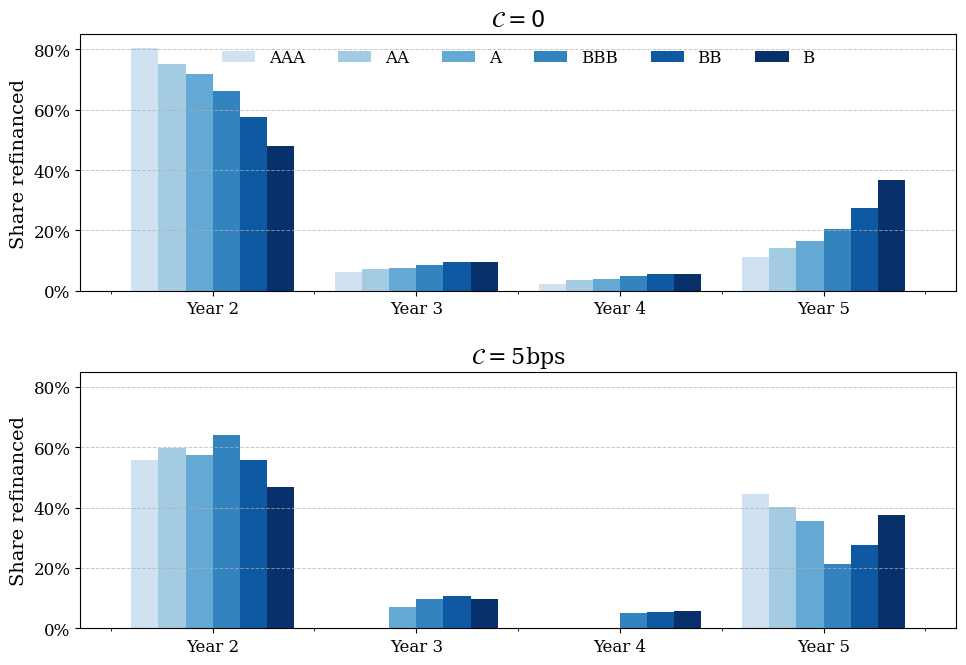

In [13]:
C_0_dist = pd.read_excel('data/RefinancingYearDistributionResults.xlsx', sheet_name='C=0new', header=0)
C_5bps_dist = pd.read_excel('data/RefinancingYearDistributionResults.xlsx', sheet_name='C=5bps+2new', header=0)


years = ['Year 2', 'Year 3', 'Year 4', 'Year 5']
ratings = C_0_dist['Rating']


data_C_0 = C_0_dist.set_index('Rating').T
data_C_5bps = C_5bps_dist.set_index('Rating').T


colors = plt.cm.Blues(np.linspace(0.2, 1, len(data_C_0.columns)))


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=True)

# Formatter for percentages
percentage_formatter = FuncFormatter(lambda x, _: f'{x * 100:.0f}%')

# Plot the first dataset (C=0)
data_C_0.plot(kind='bar', ax=axes[0], width=0.8, color=colors)
axes[0].set_title('$\mathcal{C}= 0$', fontsize=16)
axes[0].set_ylabel('Share refinanced', fontsize=14)
axes[0].legend(
    fontsize=12,
    ncol=len(data_C_0.columns),
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    frameon=False
)
axes[0].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axes[0].yaxis.set_major_formatter(percentage_formatter)
#axes[0].yaxis.set_major_locator(MaxNLocator(nbins=13)) 
axes[0].set_ylim(0, 0.85)  
axes[0].tick_params(axis='y', labelsize=12)  

# Plot the second dataset (C=5bps)
data_C_5bps.plot(kind='bar', ax=axes[1], width=0.8, color=colors)
axes[1].set_title('$\mathcal{C}= $5bps', fontsize=16)
axes[1].set_ylabel('Share refinanced', fontsize=14)
axes[1].grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
axes[1].yaxis.set_major_formatter(percentage_formatter)
#axes[1].yaxis.set_major_locator(MaxNLocator(nbins=13)) 
axes[1].legend([], [], frameon=False) 
axes[1].set_ylim(0, 0.85) 
axes[1].tick_params(axis='y', labelsize=12) 

axes[0].set_xticks(range(len(data_C_0.index)))
axes[0].set_xticklabels(years, rotation=0, fontsize=12)  # Add tick labels for the top plot
axes[0].tick_params(axis='x', labelbottom=True)  # Ensure x-axis labels are visible

axes[1].set_xticks(range(len(data_C_5bps.index)))
axes[1].set_xticklabels(years, rotation=0, fontsize=12)



plt.xticks(rotation=0)
plt.tight_layout()


plt.show()

In [ ]:
CLO = md.CLOModel(q=10000)
transaction_cost_rate = 0.0
transaction_cost_flat = 0
All_simulated_Values = CLO.GBM(risk_neutral=True)





BaselineCLO['C'] = BaselineCLO['face value'] * transaction_cost_rate + transaction_cost_flat
print(BaselineCLO)

AAA_Cashflow_outcomes = []
AA_Cashflow_outcomes = []
A_Cashflow_outcomes = []
BBB_Cashflow_outcomes = []
BB_Cashflow_outcomes = []
B_Cashflow_outcomes = []

tranche_lists = {
    'AAA': AAA_Cashflow_outcomes,
    'AA': AA_Cashflow_outcomes,
    'A': A_Cashflow_outcomes,
    'BBB': BBB_Cashflow_outcomes,
    'BB': BB_Cashflow_outcomes,
    'B': B_Cashflow_outcomes
}


for i in range(5000):
    Simulated_Values = All_simulated_Values[:, i, :]
    CLOi = BaselineCLO.copy()
    for year in range((CLO.T-CLO.noncallperiod+1)):
        
        Informed_values = Simulated_Values[CLO.noncallperiod+year]
        
        New_expectation = CLO.ExpSimulation(CLO.T-CLO.noncallperiod-year,Informed_values)
        
        ExpectedCF_CLO = np.sum(New_expectation, axis=1)
        CLOi[f'New Market Value {CLO.noncallperiod+year}'] = CLOi['aggregate face value'].apply(
            lambda agg_face_value: ((np.minimum(ExpectedCF_CLO, agg_face_value)).mean())* np.exp(-CLO.rf * (CLO.T-CLO.noncallperiod-year)))
        
        CLOi[f'MV_{CLO.noncallperiod+year}'] = CLOi[f'New Market Value {CLO.noncallperiod+year}'] - CLOi[f'New Market Value {CLO.noncallperiod+year}'].shift(1)
        CLOi.loc['AAA', f'MV_{CLO.noncallperiod+year}'] = CLOi.loc['AAA', f'New Market Value {CLO.noncallperiod+year}']
        CLOi.drop(columns=f'New Market Value {CLO.noncallperiod+year}', inplace=True)
        CLOi[f'Call Price {CLO.noncallperiod+year}'] = CLOi['face value']*np.exp(-CLOi['Yield']/100*(CLO.T-CLO.noncallperiod-year))
        CLOi[f't={CLO.noncallperiod + year}'] = np.where(
            (CLOi.index != 'Equity') & (CLOi[f'Call Price {CLO.noncallperiod + year}'] + CLOi['C'] < CLOi[f'MV_{CLO.noncallperiod + year}']),
            1,
            0
        )
        
        CLOi[f'Cashflow_{CLO.noncallperiod+year}'] = CLOi[f'Call Price {CLO.noncallperiod+year}']*CLOi[f't={CLO.noncallperiod + year}']


    ResultCLOi = CLOi[['Cashflow_2', 'Cashflow_3', 'Cashflow_4', 'MV_5']]
    #print(CLOi)
    #print(ResultCLOi)

    ResultCLOi.columns = ["2", "3", "4", "5"]

    # Ensure each tranche only has one cashflow by setting subsequent cashflows to 0 after the first one
    for tranche in ResultCLOi.index:
        cashflow_found = False
        for year in ["2", "3", "4", "5"]:
            if ResultCLOi.loc[tranche, year] != 0 and not cashflow_found:
                cashflow_found = True  # Mark that a cashflow has been found
            elif cashflow_found:
                ResultCLOi.loc[tranche, year] = 0  # Set to 0 if a cashflow was already found in an earlier year

    ResultCLOi['Future Value at Year 5'] = sum(
        ResultCLOi[year] * np.exp(CLO.rf * (5 - int(year))) for year in ["2", "3", "4", "5"]
    )
    
    for tranche in tranche_lists.keys():
        tranche_lists[tranche].append(ResultCLOi.loc[tranche, 'Future Value at Year 5'])
    
    #print(ResultCLOi)


print((np.mean(AAA_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))
print((np.mean(AA_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))
print((np.mean(A_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))
print((np.mean(BBB_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))
print((np.mean(BB_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))
print((np.mean(B_Cashflow_outcomes)) * np.exp(-CLO.rf * 5))

    